In [8]:
%matplotlib inline
import os
import sys
import pathlib
sys.path.append(os.path.join(str(pathlib.Path().resolve()), '../lib'))
from fancy_plot import *
import numpy as np
import pickle
from scipy.optimize import curve_fit
import glob
import pandas as pd
import datetime
import pytz
from tzwhere import tzwhere
import pickle
from datetime import datetime
def to_flxnet_date(time):
    return np.int64('{}{:02d}{:02d}{:02d}{:02d}'.format(time.year, time.month, time.day,
                                                        time.hour,time.minute)) 

In [21]:
with open('/work/bd1231/tglauch/VPRM_output_modis_new_sites_new/h18v3_2012.pickle', 'rb') as ifile:
    in1 = pickle.load(ifile)

In [23]:
in1 = [i[0] for i in in1['DE-Geb']['input_data']]

In [24]:
with open('/work/bd1231/tglauch/VPRM_output_modis_new_smearing_lowess/h18v3_2012.pickle', 'rb') as ifile:
    in2 = pickle.load(ifile)

In [25]:
in2 = [i[0] for i in in2['DE-Geb']['input_data']]

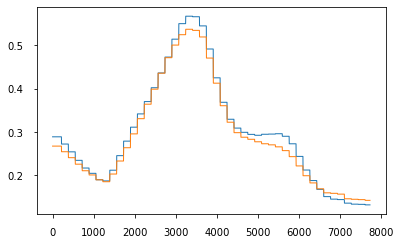

In [26]:
fig, ax = newfig(0.9)
ax.plot(range(len(in1)), in1)
ax.plot(range(len(in2)), in2)
fig.show()

In [4]:
def make_prediction_for_site(site, folder, target_key,
                             res_gpp, res_nee,
                             skip_bad=True):
    spred, targets, tmps_return = None, None, None
    for f in glob.glob(folder):
        with open(f, 'rb') as ifile:
            idata = pickle.load(ifile)
        if site not in idata.keys():
            continue
        ipt = np.array(idata[site]['input_data'])
        tmsp = np.array(idata[site]['input_data_timestamps'])
        flxnet = idata[site]['fluxnet_data']
        targets = []
        inputs = []
        tmps_return = []
        for c, t in enumerate(tmsp):
            if (t.hour % 1 != 0):
                continue
            try:
                if skip_bad & (float(flxnet.loc[flxnet['datetime_utc'] == t]['NEE_VUT_REF_QC'].iloc[0])>1):
                    continue
                a = float(flxnet.loc[flxnet['datetime_utc'] == t][target_key].iloc[0])
                if a < -1000:
                    continue
            except:
                continue
            targets.append(a)
            inputs.append(ipt[c])
            tmps_return.append(t)
        tmps_return = np.array(tmps_return)   
        inputs = np.array(inputs)
        inputs[:,2] = inputs[:,2] 
        targets = np.array(targets)
        if len(inputs) == 0:
            print('Nothing to plot. continue')
            return None, None, None
        if 'NEE' in target_key:
            spred = -(res_gpp[0][0] * inputs[:,1] * inputs[:,4]  * inputs[:,3]) * inputs[:,0] * inputs[:,2] / (1 + inputs[:,2]/res_gpp[0][1]) + res_nee[0][0] * (inputs[:,5])  + res_nee[0][1]
        else:
            spred = (res_gpp[0][0] * inputs[:,1] * inputs[:,4]  * inputs[:,3]) * inputs[:,0] * inputs[:,2] / (1 + inputs[:,2]/res_gpp[0][1])
            targets[targets<0] = 0
    return spred, targets, tmps_return


In [5]:
site_dict = {'grassland': ['AT-Neu', 'CH-Cha', 'CH-Fru', 'CZ-BK2', 'DE-Gri', 'DE-RuR', 'IT-MBo', 'IT-Tor'],
             'mixed_forests': ['BE-Bra', 'BE-Vie', 'CH-Lae'],
             'cropland': ['BE-Lon', 'CH-Oe2', 'DE-Geb', 'DE-Kli', 'DE-RuS', 'FR-Gri', 'IT-BCi', 'IT-CA2'],
             'evergeen': ['CH-Dav', 'CZ-BK1', 'DE-Lkb', 'DE-Obe', 'DE-Tha', 'FI-Hyy', 'FI-Let', 'FI-Sod',
                          'IT-Lav', 'IT-Ren', 'IT-SRo', 'NL-Loo', 'RU-Fyo'],
             'wetland': ['CZ-wet', 'DE-Akm', 'DE-SfN', 'DE-Spw', 'FR-Pue', 'IT-Cp2'],
             'deciduous': ['DE-Hai', 'DE-Lnf', 'DK-Sor', 'FR-Fon', 'IT-CA1', 'IT-CA3', 'IT-Col', 'IT-Ro2'],
             'shrubland': ['ES-Amo', 'ES-LJu', 'IT-Noe']}

veg_type_id = {'grassland': 7, 'mixed_forests': 3 , 'cropland':6, 
               'evergeen': 1, 'deciduous': 2, 'shrubland':4} # 'wetland': 8


In [6]:
input_data= {'modis': '/work/bd1231/tglauch//VPRM_output_modis_new_smearing_lowess/*.pickle'} #'viirs': '/work/bd1231/tglauch//VPRM_output_viirs_new_smearing_lowess/*.pickle',


In [ ]:
MSE GPP: 40.57261181296563
MSE NEE: 23.178037863426592

In [ ]:
MSE GPP: 40.81998629263697
MSE NEE: 23.157272967624095

In [ ]:

plots = False
fit_params = dict()
res_dict = dict()

for key in input_data.keys():
    t_dict = dict()
    
    print('-----')
        
    temp_dict = dict()
    for cvt, veg_type in enumerate(site_dict.keys()):
        print(veg_type)
        targets_gpp,  targets_nee, inputs = [], [], []
        lens = [0]
        len0 = 0

# -------------------------- Read Data -------------------------------- 

        for f in glob.glob(input_data[key]):
            with open(f, 'rb') as ifile:
                idata = pickle.load(ifile)
            for site in site_dict[veg_type]:
                if site not in idata.keys():
                    continue
                print(site)
                ipt = np.array(idata[site]['input_data'])
                tmsp = np.array(idata[site]['input_data_timestamps'])
                flxnet = idata[site]['fluxnet_data']
                mask = (flxnet['NEE_VUT_REF_QC'] <= 1)  & (np.abs(flxnet['WS']) < 0.1  )
                flxnet = flxnet[mask]
                idata[site]['input_data_timestamps'] = [to_flxnet_date(i) for i in idata[site]['input_data_timestamps']]
                mask1 = [True if i in idata[site]['input_data_timestamps'] else False
                         for i in flxnet['TIMESTAMP_START'].values]
                mask2 = [True if i in flxnet['TIMESTAMP_START'].values else False
                         for i in idata[site]['input_data_timestamps']]
                targets_nee.extend(list(flxnet['NEE_VUT_REF'][mask1].values))
                inputs.extend(list(ipt[mask2]))
                targets_gpp.extend(list(flxnet['GPP_DT_VUT_REF'][mask1].values))
                lens.append(len(targets_gpp)-len0)
                len0 = len(targets_gpp)

        
        # Prepare Data
        inds = []
        lens = np.array(lens)
        targets_nee = np.array(targets_nee)
        targets_gpp = np.array(targets_gpp)
        inputs = np.array(inputs)

        if np.sum(lens) == 0:
            continue
        num_inds_per_site = np.min(lens[lens>0])
        cum_len = np.cumsum(lens)
        for i in range(len(cum_len)-1):
            if cum_len[i] == cum_len[i+1]:
                continue
            inds.append(np.random.choice(np.arange(cum_len[i], cum_len[i+1]),
                                         num_inds_per_site))

        inds = np.concatenate(inds)  
        inputs = inputs[inds]
        targets_gpp = targets_gpp[inds]
        targets_nee = targets_nee[inds]
        mask = targets_gpp > 0.5
        mask_nan = np.all(np.isfinite(inputs), axis=1)
        mse_min = 1e4
        
        print(len(targets_gpp[mask_nan & mask]))
        #Make Fits
        for i in range(5):

            res_gpp_t = curve_fit(lambda x, lamb, par0: (lamb * x[:,1] * x[:,4]  * x[:,3]) * x[:,0] * x[:,2] / (1 + x[:,2]/par0),
                            inputs[mask_nan & mask], targets_gpp[mask_nan & mask], maxfev=5000, p0=[np.random.uniform(0,1), np.random.uniform(0,1)]) 

            spred = (res_gpp_t[0][0] * inputs[:,1] * inputs[:,4]  * inputs[:,3]) * inputs[:,0] * inputs[:,2] / (1 + inputs[:,2]/res_gpp_t[0][1])

            mse = (np.square(targets_gpp[mask_nan & mask] - spred[mask_nan & mask])).mean()
            if mse < mse_min:
                res_gpp = res_gpp_t
                mse_min = mse

        print('MSE GPP:', mse_min)
        mse_min = 1e4

        for i in range(5):

            res_nee_t = curve_fit(lambda x, a,b : -(res_gpp[0][0] * x[:,1] * x[:,4]  * x[:,3]) * x[:,0] * x[:,2] / (1 + x[:,2]/res_gpp[0][1]) + a * x[:,5] + b,
                            inputs[mask_nan], targets_nee[mask_nan], maxfev=5000, p0=[np.random.uniform(0,1), np.random.uniform(0,1)])  

            spred = -(res_gpp[0][0] * inputs[:,1] * inputs[:,4]  * inputs[:,3]) * inputs[:,0] * inputs[:,2] / (1 + inputs[:,2]/res_gpp[0][1]) + res_nee_t[0][0] * (inputs[:,5])  + res_nee_t[0][1]

            mse = (np.square(targets_nee[mask_nan] - spred[mask_nan])).mean()

            if mse < mse_min:
                res_nee = res_nee_t
                mse_min = mse

        print('MSE NEE:', mse_min)
        temp_dict[veg_type_id[veg_type]] = [res_gpp, res_nee]

        print('Make plots')
        target_key  = 'NEE_VUT_REF'  #'GPP_DT_VUT_REF' #

# -------------------------- Plots for Cross-Checks --------------------------------  

        for site in site_dict[veg_type]:

            spred, targets, tmsp = make_prediction_for_site(site, input_data[key], 
                                                            target_key, res_gpp, res_nee)
            if spred is None:
                continue
            ax_max = np.max([spred, targets])
            ax_min = np.min([spred, targets])
            t_dict[site] = [spred, targets, tmsp]
            if plots is False:
                continue
            # Plot 1
            fig, ax = newfig(0.9,ratio=1.0)
            ax.scatter(targets, spred, s=3)
            ax.set_xlabel('Target')
            ax.set_ylabel('Prediction')
            ax.text(0.1, 0.9, site,
              horizontalalignment='left',
              verticalalignment='top',
              transform = ax.transAxes)
            ax.plot([ax_min, ax_max], [ax_min, ax_max], color='k',
                 lw=2)
            fig.show()

            # Plot 2
            fig, ax = newfig(2.0, ratio=0.3)
            ax.plot(range(len(targets)), targets, lw=1, color='k',
                 marker='o', ms=1)
            ax.plot(range(len(spred)), spred, lw=1,
                 marker='o', ms=1)
            ax.text(0.1, 0.9, site,
              horizontalalignment='left',
              verticalalignment='top',
            transform = ax.transAxes)
            ax.set_xlim(3000,3500)
            fig.show()

            # Plot 3
            month_values_pred = []
            temp_values_pred = [] 
            month_values_truth = []
            temp_values_truth = [] 
            c_month = tmsp[0].month
            for c, i in enumerate(tmsp):
                if i.month != c_month:
                    c_month = i.month
                    month_values_pred.append(np.mean(temp_values_pred))
                    month_values_truth.append(np.mean(temp_values_truth))
                    temp_values_truth = [] 
                    temp_values_pred = []
                temp_values_pred.append(spred[c])
                temp_values_truth.append(targets[c])
            fig, ax = newfig(0.9)
            ax.plot(range(len(month_values_truth)), month_values_truth, color='k',
                 marker='o')
            ax.plot(range(len(month_values_pred)), month_values_pred, color='b',
             marker='o')
            ax.text(0.0, 0.9, site,
              horizontalalignment='left',
              verticalalignment='top',
              transform = ax.transAxes)
            fig.show()
    res_dict[key] = t_dict
    fit_params[key] = temp_dict

In [6]:
for k in ['modis', 'viirs']:
    o_dict = dict()
    for vkey in sorted(fit_params[k]):
        o_dict[vkey] = dict(zip(['lamb', 'par0', 'alpha', 'beta'], list(np.concatenate([fit_params[k][vkey][0][0], fit_params[k][vkey][1][0]]))))
    with open('/home/b/b309233/{}.pickle'.format(k), 'w+b') as ofile:
        pickle.dump(o_dict, ofile)
    print(o_dict)

{1: {'lamb': 0.19645807321392605, 'par0': 442.04318935988385, 'alpha': 0.2547037111141156, 'beta': 0.3415718032138659}, 2: {'lamb': 0.13639411045370545, 'par0': 422.8723679465238, 'alpha': 0.08309598739186251, 'beta': 1.734416890080584}, 3: {'lamb': 0.1468218040389907, 'par0': 454.3658232172629, 'alpha': 0.23629819464334334, 'beta': 1.039345062863741}, 4: {'lamb': 0.10888457197009463, 'par0': 408.17028270338534, 'alpha': 0.09660816369073202, 'beta': -0.2439372956806372}, 6: {'lamb': 0.10503803659290176, 'par0': 670.5991266093354, 'alpha': 0.18385100050024483, 'beta': 0.1708525518514339}, 7: {'lamb': 0.11797988006188123, 'par0': 607.9584378249552, 'alpha': 0.37353056078826224, 'beta': 0.5719985800316121}}
{1: {'lamb': 0.20092564259686285, 'par0': 434.9995402700874, 'alpha': 0.2470885787378914, 'beta': 0.30943798783919724}, 2: {'lamb': 0.13495929245368016, 'par0': 408.68213231387693, 'alpha': 0.08589216910237052, 'beta': 1.7328190603381008}, 3: {'lamb': 0.14713448853062241, 'par0': 468.6

In [14]:
with open('/home/b/b309233/fit_res_modis.pickle', 'w+b') as ofile:
    pickle.dump(fit_res_dict_modis, ofile)

AT-Neu
CH-Cha
CH-Fru
CZ-BK2
DE-Gri
DE-RuR
IT-MBo
IT-Tor
BE-Bra
BE-Vie
CH-Lae
BE-Lon
CH-Oe2
DE-Geb
DE-Kli
DE-RuS
FR-Gri
IT-BCi
IT-CA2
CH-Dav
CZ-BK1


/tmp/ipykernel_1260464/4163378663.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize(2.0, ratio=0.3))


DE-Lkb
DE-Obe
DE-Tha
FI-Hyy
FI-Let
FI-Sod
IT-Lav
IT-Ren
IT-SRo
NL-Loo
RU-Fyo
DE-Hai
DE-Lnf
DK-Sor
FR-Fon
IT-CA1
IT-CA3
IT-Col
IT-Ro2
ES-Amo
ES-LJu
IT-Noe


/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


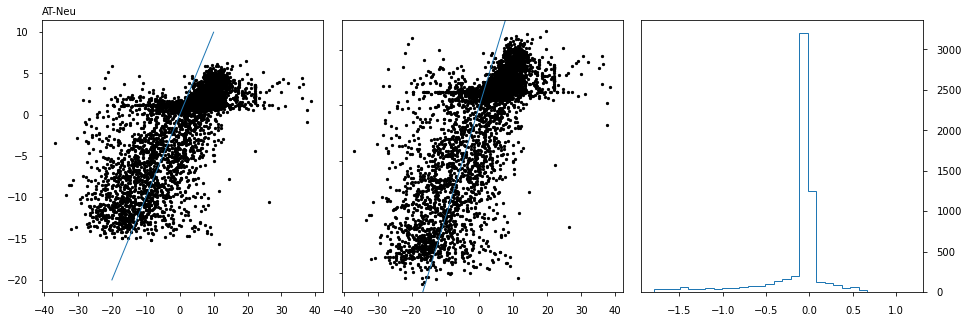

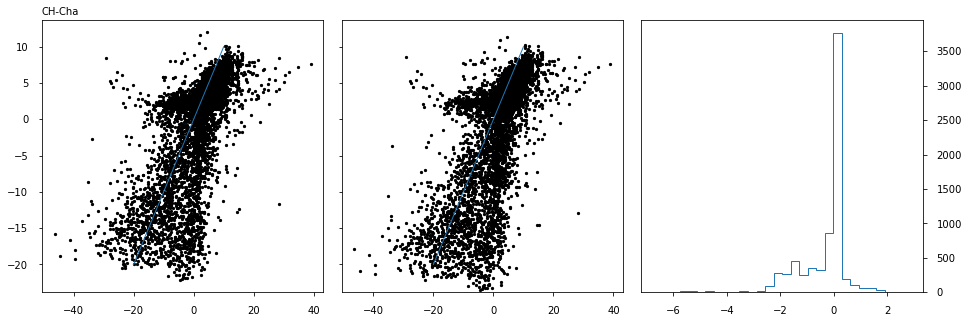

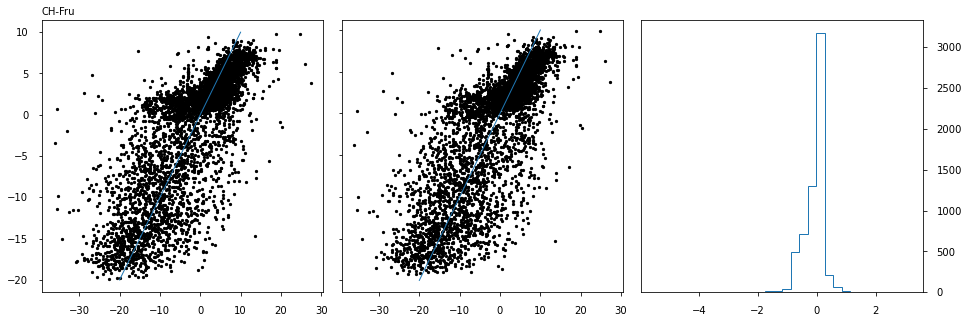

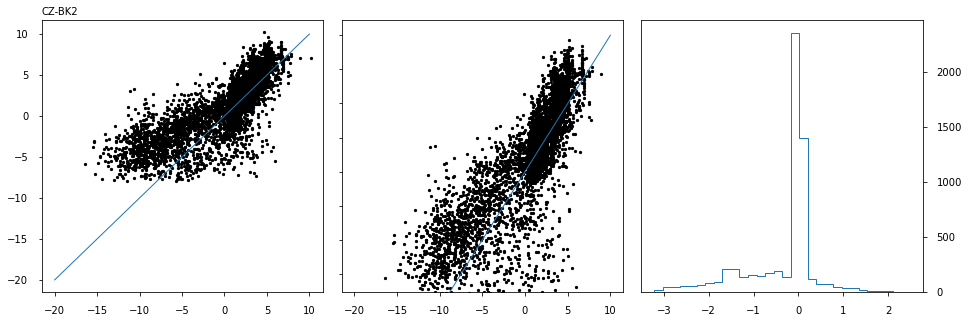

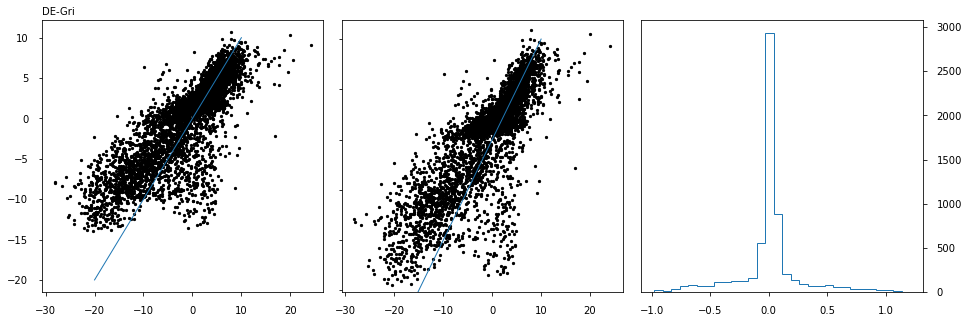

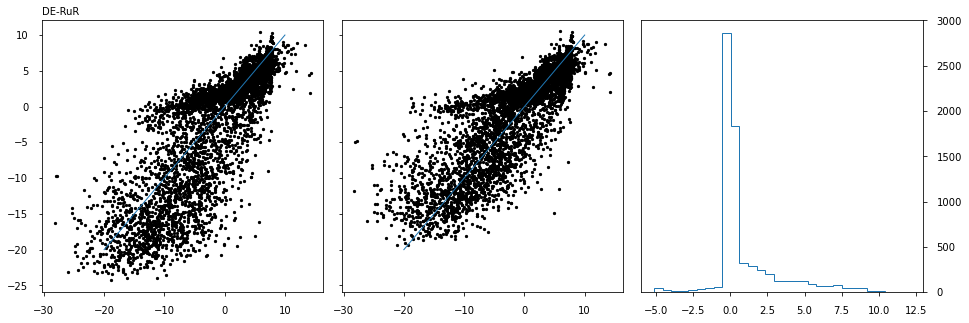

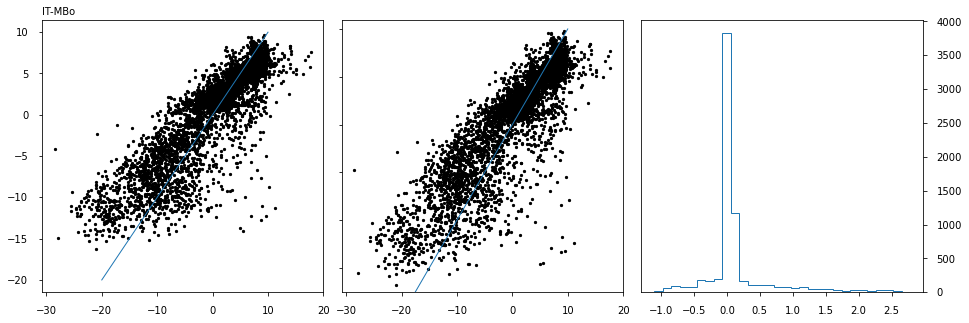

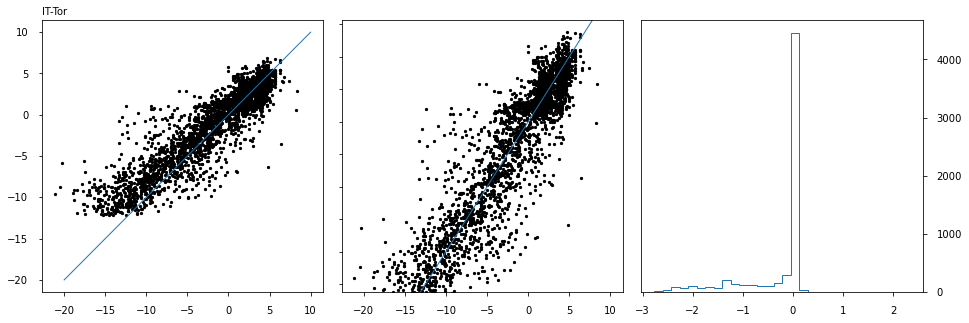

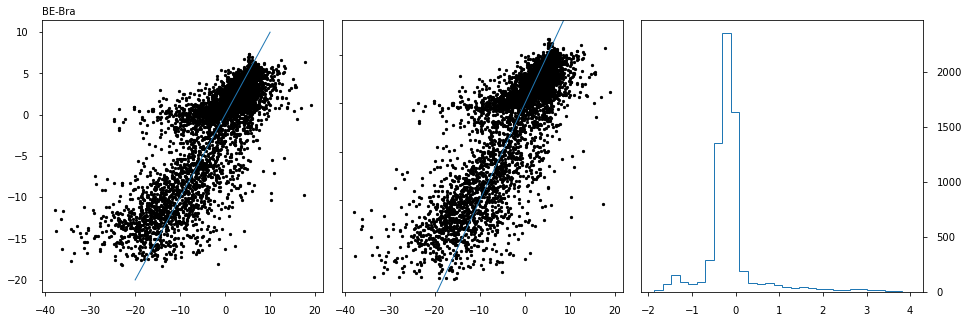

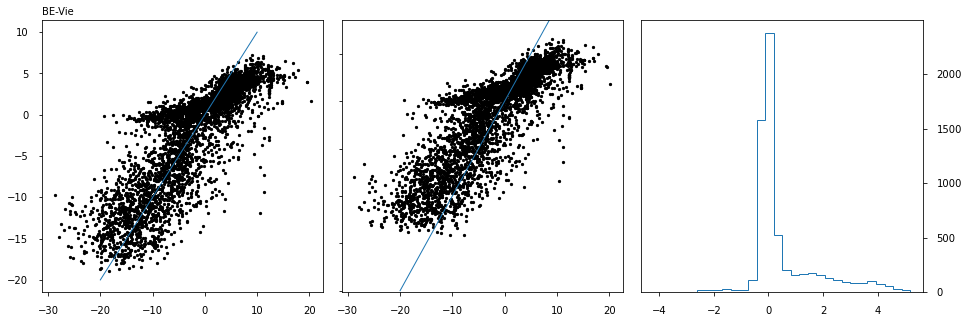

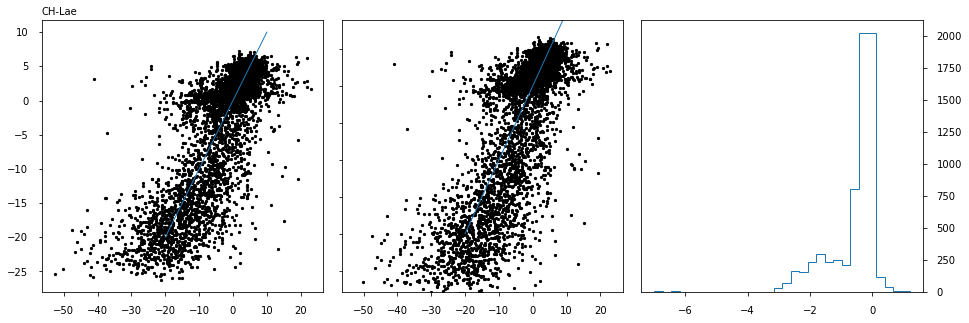

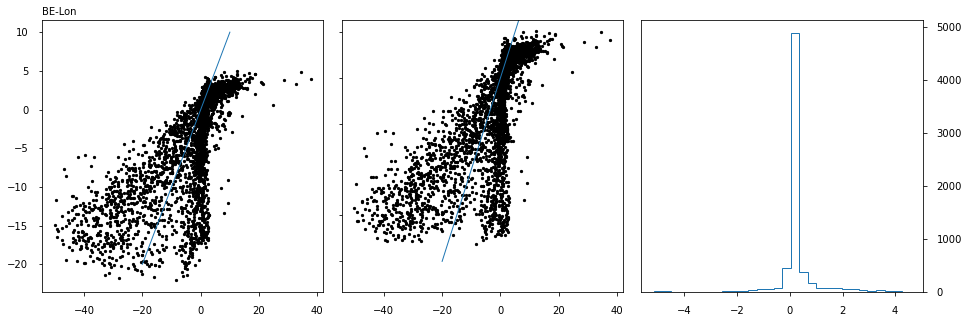

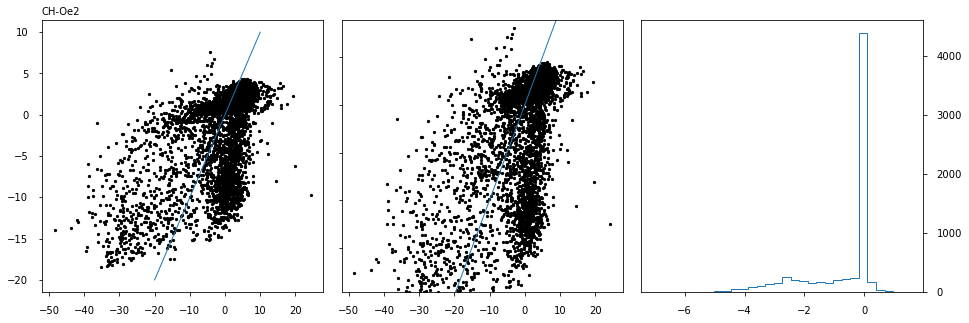

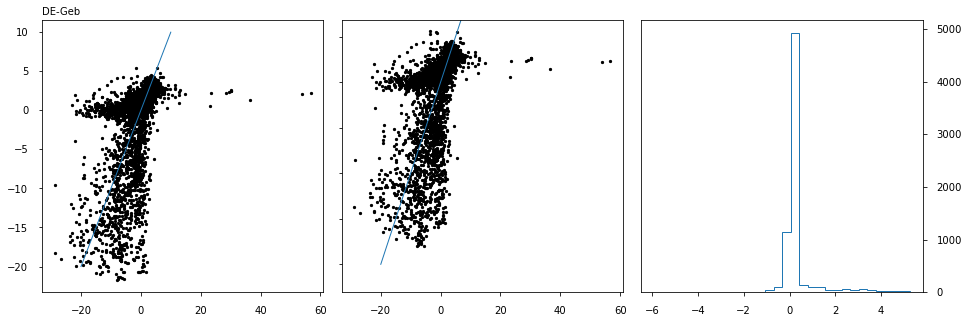

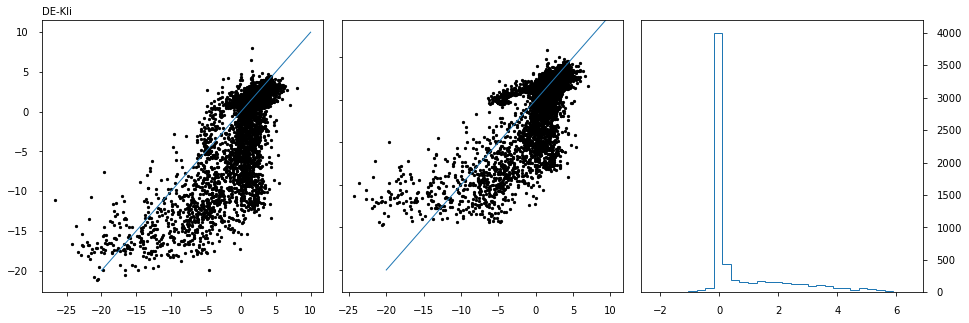

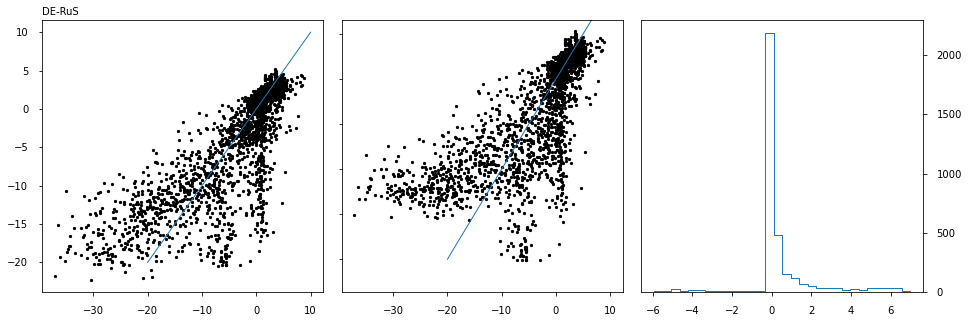

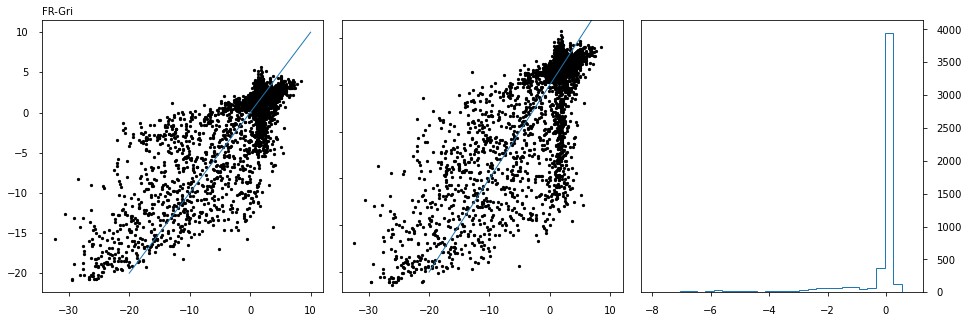

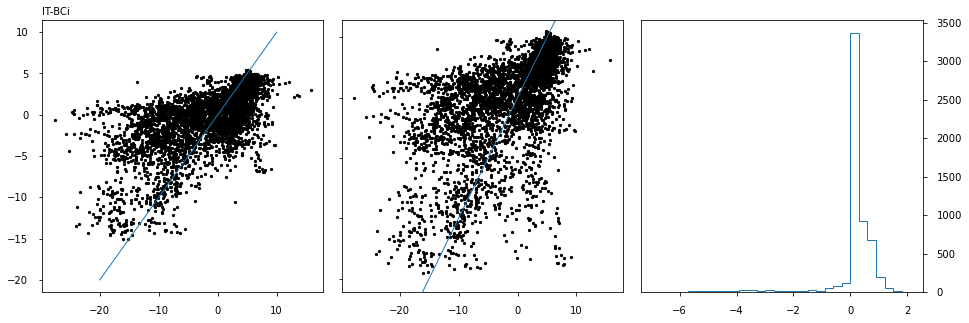

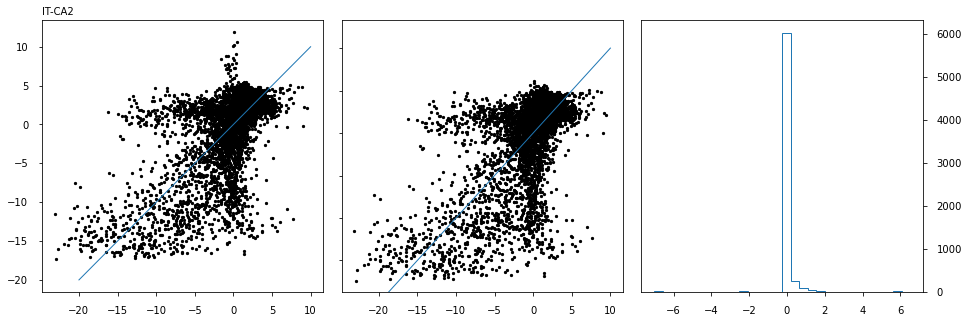

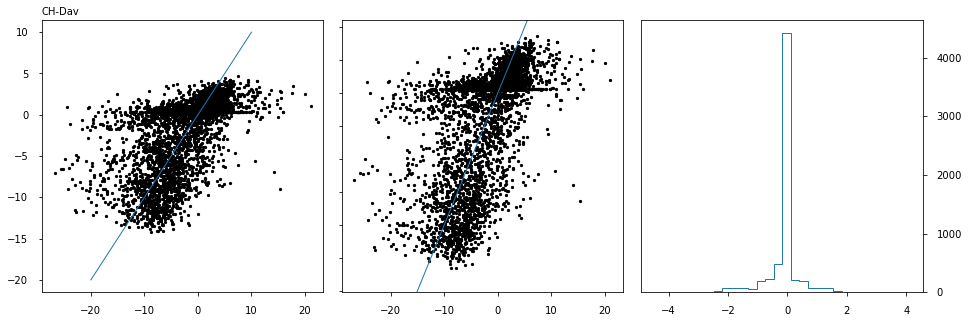

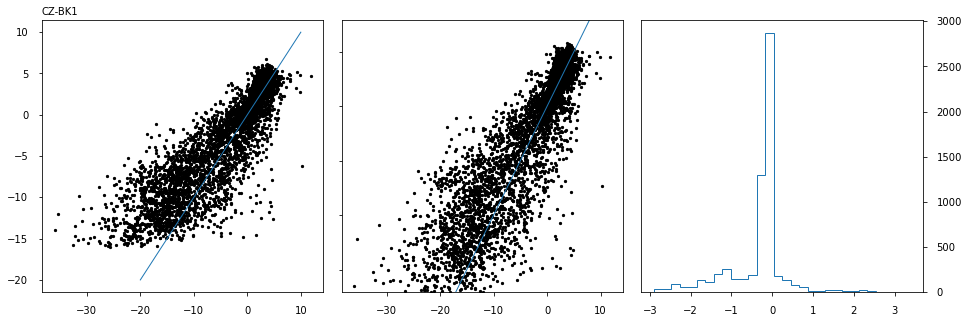

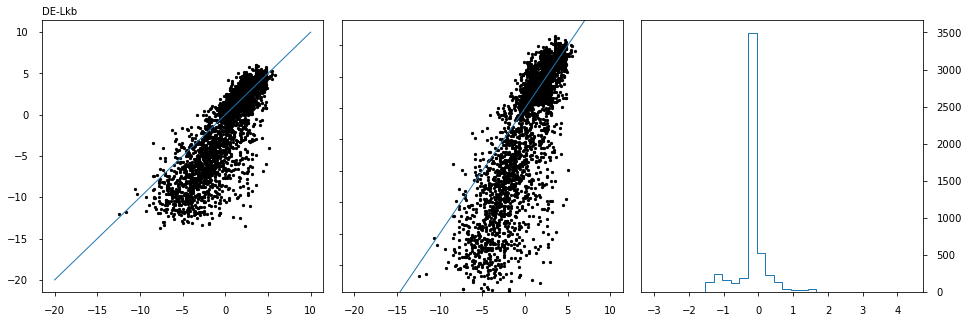

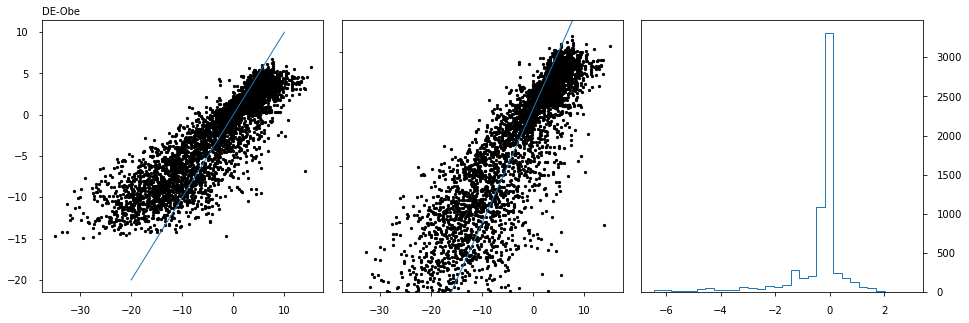

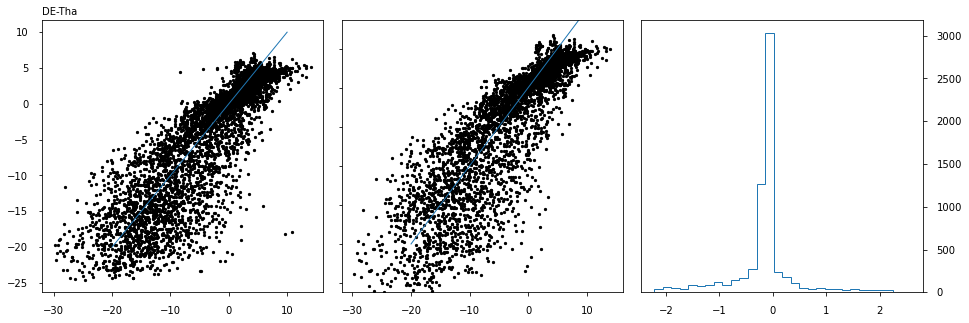

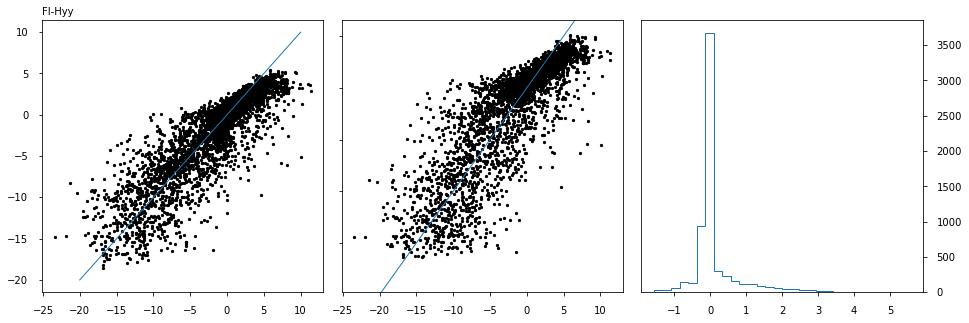

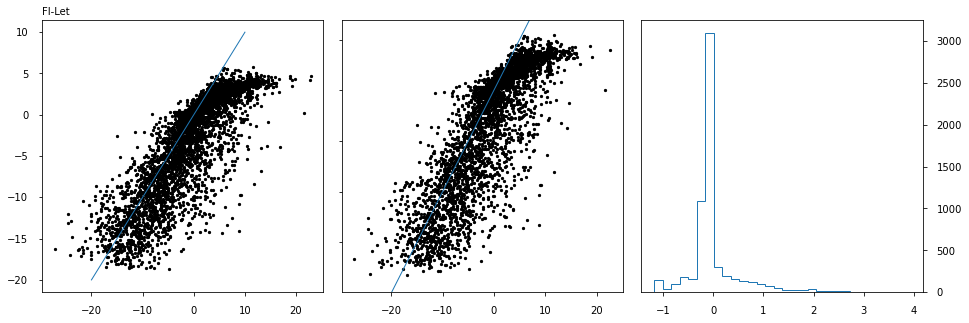

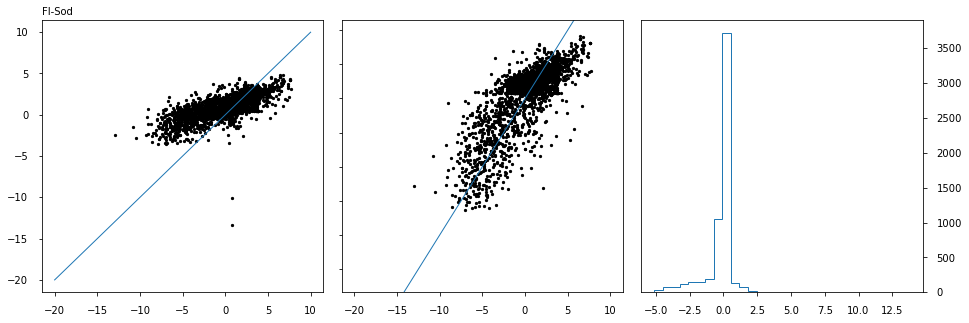

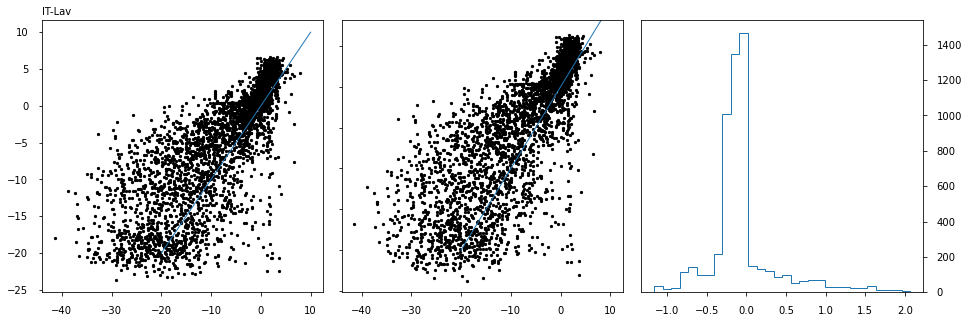

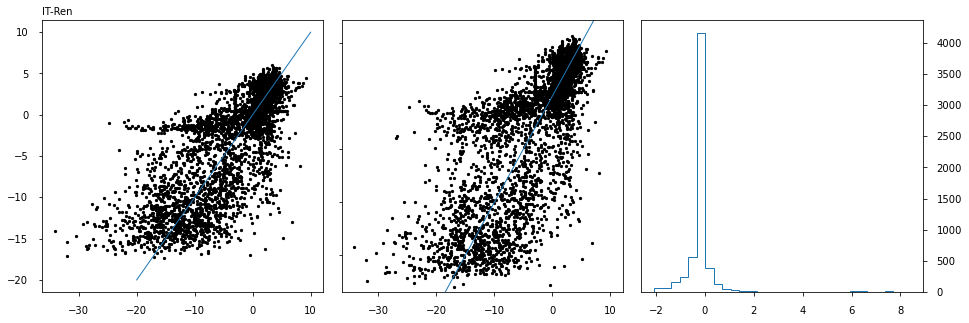

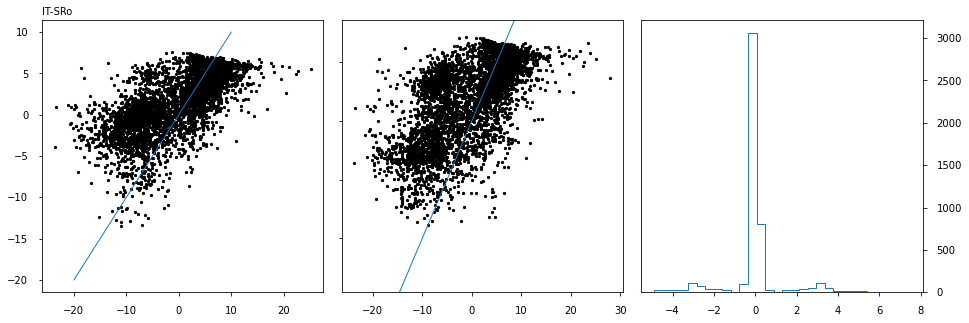

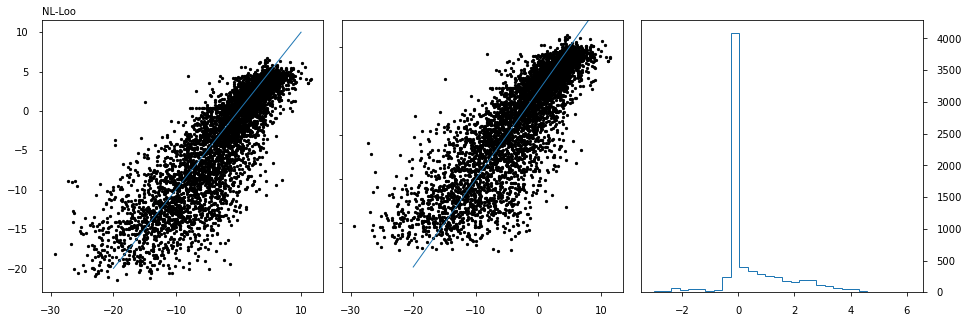

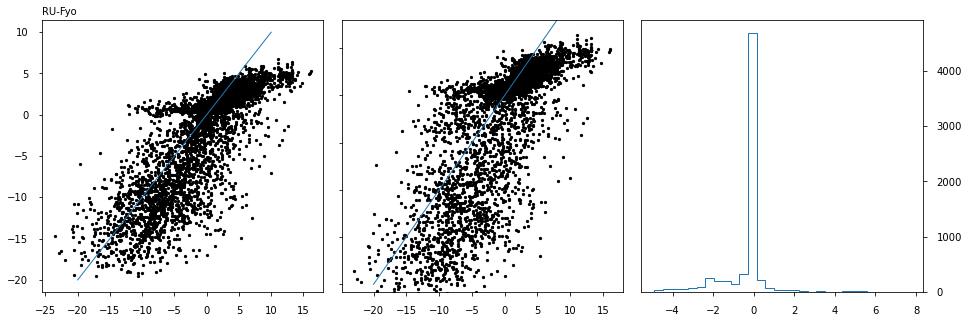

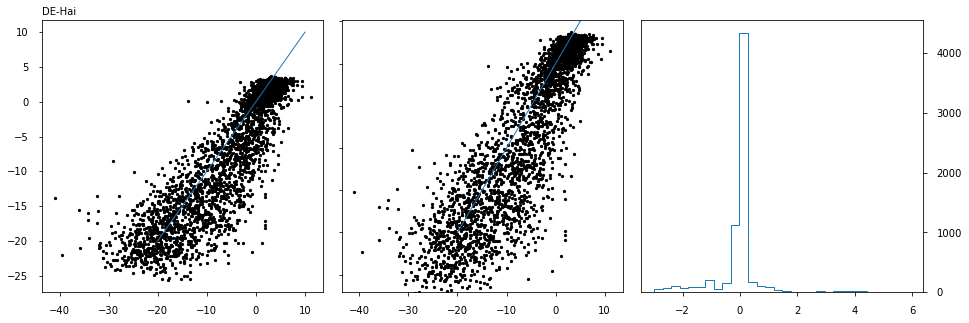

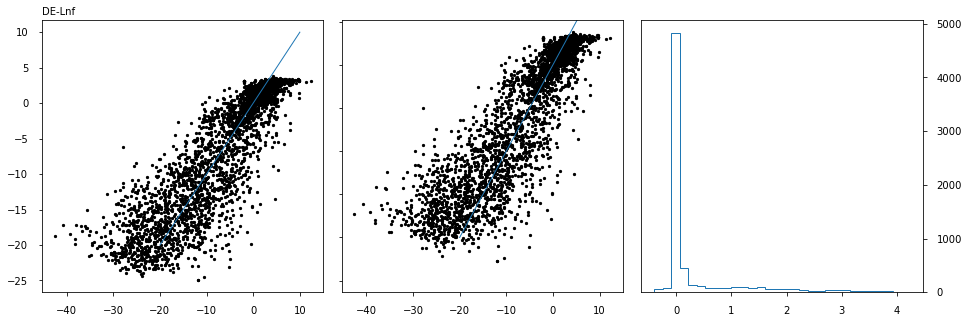

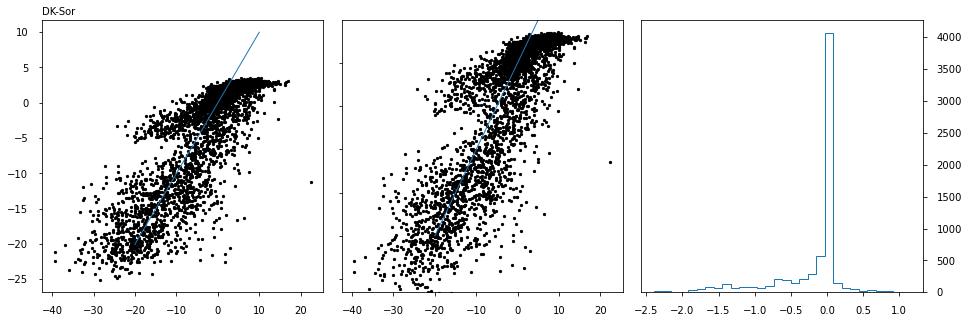

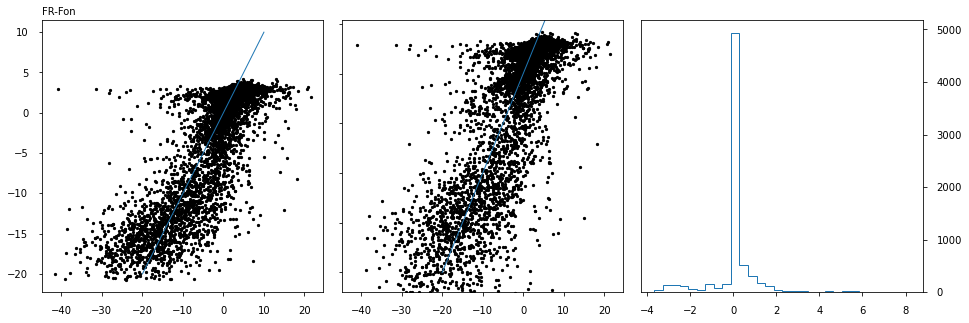

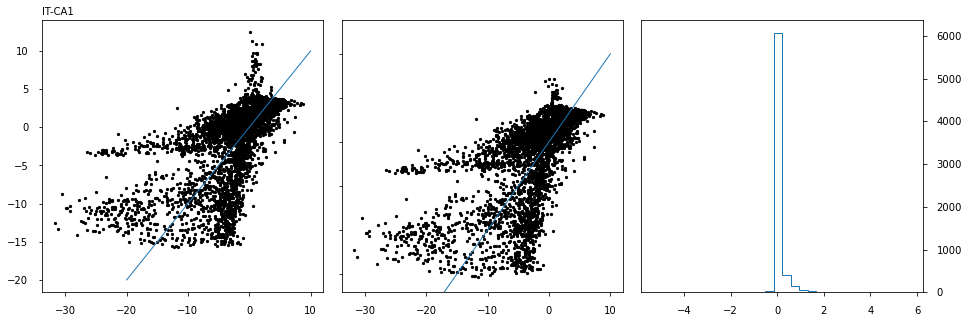

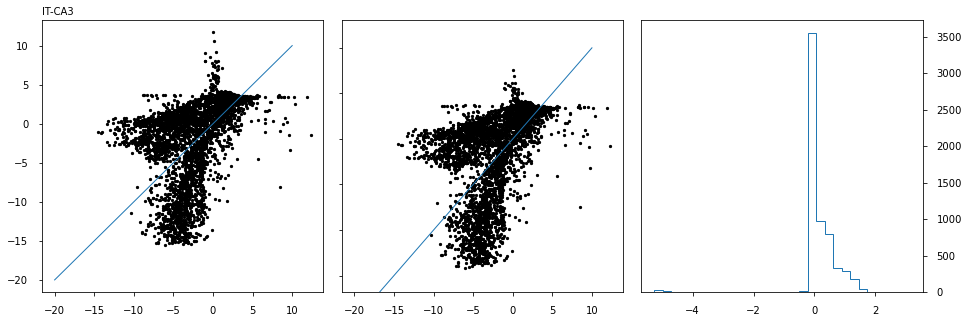

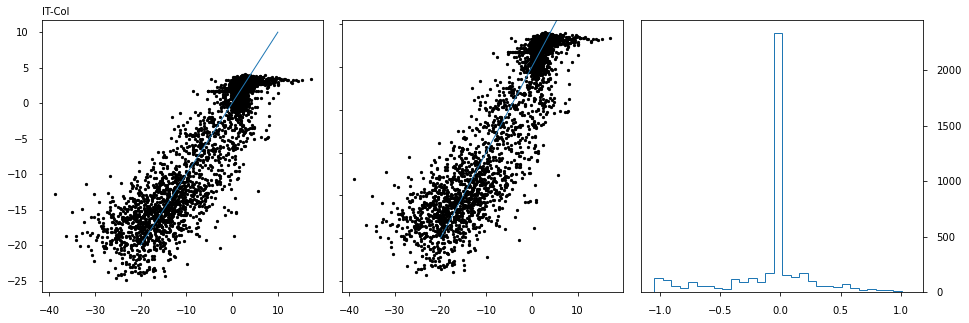

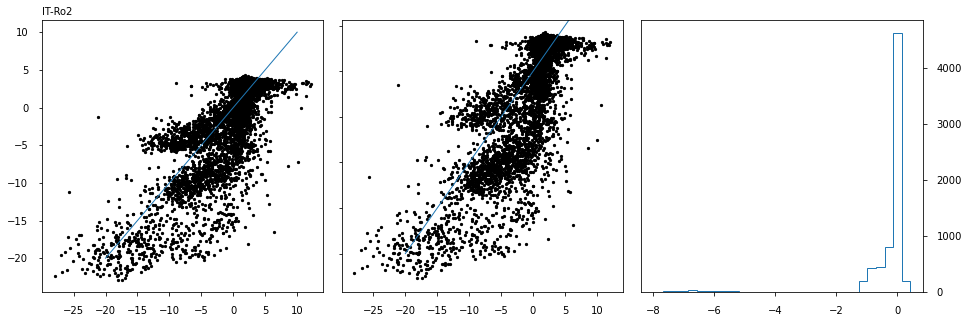

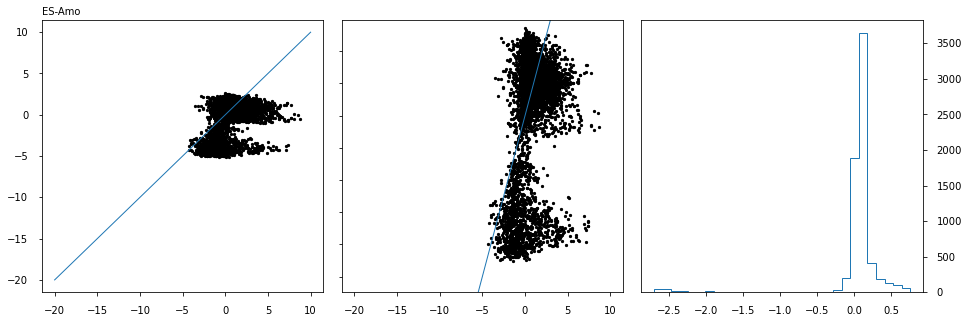

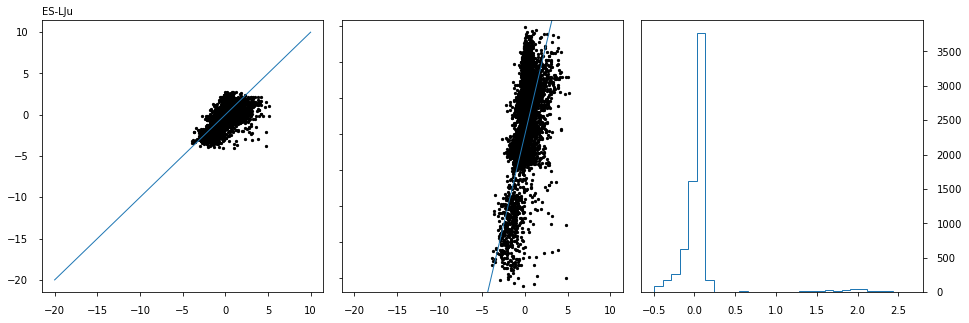

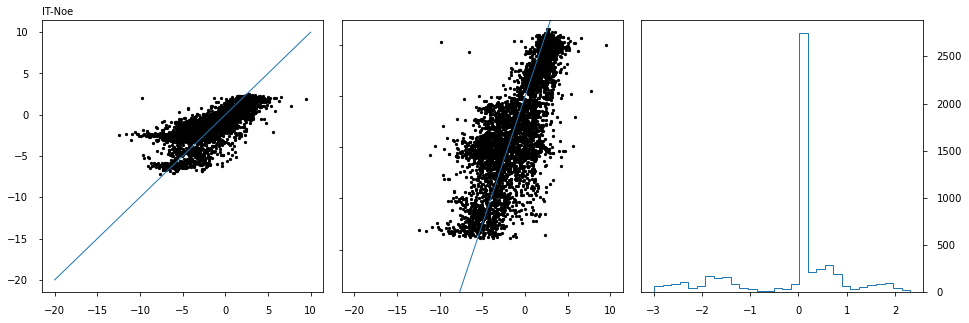

In [12]:
for key in res_dict['modis'].keys():
    print(key)
    inds1 = []
    inds2 = []
    for c, t in enumerate(res_dict['viirs'][key][2]):
        ti = np.where(t==res_dict['modis'][key][2])[0]
        if len(ti)>0:
            inds1.append(c)
            inds2.append(ti[0])
    fig = plt.figure(figsize=figsize(2.0, ratio=0.3))
    ax1 = fig.add_axes((0.,0, 0.31, 1.0))
    ax2 = fig.add_axes((0.33,0, 0.31, 1.0))
    ax3 = fig.add_axes((0.66,0, 0.31, 1.0))
    ax1.scatter(res_dict['modis'][key][1][inds2], res_dict['modis'][key][0][inds2], color='k', s=5)
    ax2.scatter(res_dict['viirs'][key][1][inds1], res_dict['viirs'][key][0][inds1], color='k', s=5)
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_yticklabels([])
    ax3.hist(res_dict['viirs'][key][0][inds1] - res_dict['modis'][key][0][inds2], bins=30, histtype='step')
    ax3.yaxis.tick_right()
    ax1.plot([-20,10], [-20, 10])
    ax2.plot([-20,10], [-20, 10])
    ax1.text(0.0, 1.01, key,
          horizontalalignment='left',
          verticalalignment='bottom',
          transform = ax1.transAxes)
    fig.show()